In [ ]:
import torch
import torchvision

import os
import cv2
import numpy as np
from PIL import Image
import skimage
import random

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import models

from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict

device="cuda"

%pip install torchgeometry

from torchgeometry.losses import ssim
from IPython.display import clear_output


In [7]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceloss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)

       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

class CompLoss(nn.Module):
    def __init__(self):
        super(CompLoss, self).__init__()
        self.BCELoss = diceloss()

    def forward(self, pred, target):
        return self.BCELoss(pred, target) + ssim(pred, target, 15, "mean")

In [20]:
class SoRa(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, reg_coef=0.2):
        super(SoRa, self).__init__()
        self.reg_coef = reg_coef
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.fc_layer = nn.Linear(in_channels, out_channels, bias=bias)
        self.sora_mode = False
        self.W1 = None
        self.W2 = None
        self.g = None

    def activate(self, max_rank):
        self.sora_mode = True
        self.W1 = nn.Linear(self.in_channels, max_rank, bias=False)
        self.W2 = nn.Linear(max_rank, self.out_channels, bias=False)
        self.W2.weight = torch.nn.Parameter(torch.zeros_like(self.W2.weight), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(max_rank), requires_grad=True)
        self.fc_layer.weight.requires_grad = False

    def forward(self, x):
        res = self.fc_layer(x)
        if self.sora_mode:
            res += self.W2(self.g * self.W1(x))
        return res

    def gate(self, lr):
        assert self.sora_mode == True
        self.g.data =  torch.sgn(self.g) * torch.clamp(torch.abs(self.g) - lr * self.reg_coef, min=0)

    def freeze(self):
        assert self.sora_mode == True
        self.g.detach()
        self.W2.weight.detach()
        self.W1.weight.detach()
        self.fc_layer.weight = torch.nn.Parameter(self.fc_layer.weight + (self.g * self.W2.weight) @ self.W1.weight)
        self.sora_mode = False
        self.W1 = None
        self.W2 = None
        self.g = None


class UNet(nn.Module):

    def __init__(self, reg_coef=0.2):
        super(UNet, self).__init__()

        features = 4
        self.encoder1 = UNet._block(3, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder5 = UNet._block(features * 8, features * 16, name="enc5")
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder6 = UNet._block(features * 16, features * 16, name="enc5")
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.sora_modules = [SoRa(1024, 1024, bias=True, reg_coef=reg_coef)]
        self.flat = nn.Flatten()
        self.bottleneck = nn.Sequential(OrderedDict([("bottleneckfc", self.sora_modules[0]), ("bottleneckrelu", nn.ReLU())]))

        self.unflat = nn.Unflatten(1, (64, 4, 4))
        
        self.upconv6 = nn.ConvTranspose2d(
            features * 16, features * 16, kernel_size=2, stride=2
        )
        self.decoder6 = UNet._block((features * 16) * 2, features * 16, name="dec5")

        self.upconv5 = nn.ConvTranspose2d(
            features * 16, features * 16, kernel_size=2, stride=2
        )
        self.decoder5 = UNet._block((features * 16) * 2, features * 8, name="dec5")

        self.upconv4 = nn.ConvTranspose2d(
            features * 8, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=1, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))
        enc6 = self.encoder6(self.pool5(enc5))

        bottleneck = self.flat(self.pool6(enc6))

        bottleneck = self.bottleneck(bottleneck)

        bottleneck = self.unflat(bottleneck)
        
        dec6 = self.upconv6(bottleneck)
        dec6 = torch.cat((dec6, enc6), dim=1)
        dec6 = self.decoder6(dec6)

        dec5 = self.upconv5(dec6)
        dec5 = torch.cat((dec5, enc5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

def get_score(pred, labels):
    diff = torch.abs(pred - labels)
    score = torch.sum(1 - diff) / (torch.sum(1 + diff) + 1e-10)
    return score

In [9]:
class getDataset(Dataset):
    def __init__(self, name, indexes=None):
        self.image_path = f"{name}/images/"
        self.mask_path = f"{name}/masks/"
        self.files = os.listdir(self.image_path)

        if indexes is None:
            indexes = np.arange(len(self.files))

        self.indexes = indexes

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.GaussianBlur(5, sigma=(0.2, 0.2))
        ])

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        file = self.files[index]
        new_image = skimage.io.imread(self.image_path + file).astype(float)
        new_mask = skimage.io.imread(self.mask_path + file).astype(float) / 255

        return self.transform(new_image).float(), transforms.ToTensor()(new_mask).float()

In [10]:
from sklearn.model_selection import train_test_split

train_indexes, test_indexes = train_test_split(np.arange(4800), test_size=0.2, shuffle=True)

train_indexes

array([3317, 2155, 2859, ..., 2066, 2615, 1455])

In [11]:
dataset = getDataset("EGOHAND", train_indexes)
test_dataset = getDataset("EGOHAND", test_indexes)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [12]:
def train(model, optimizer, scheduler, train_loader, criterion, val_loader, n_epochs):

    train_losses = []
    val_losses = []

    train_acc = []
    test_acc = []

    for epoch in range(n_epochs):
        model.train()
        train_losses_per_epoch = []

        count = 0
        acc = 0

        for batch in tqdm(train_loader):
            torch.cuda.empty_cache()
            X_batch, y_batch = batch
            optimizer.zero_grad()
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
            acc += len(batch) * get_score(y_pred.to("cpu"), y_batch).item()
            count += len(batch)

        acc = acc / count

        train_acc.append(acc)

        train_losses.append(np.mean(train_losses_per_epoch))
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            count = 0
            acc = 0
            for batch in val_loader:
                torch.cuda.empty_cache()
                X_batch, y_batch = batch
                y_pred = model(X_batch.to(device))
                loss = criterion(y_pred, y_batch.to(device))
                val_losses_per_epoch.append(loss.item())
                acc += len(batch) * get_score(y_pred.to("cpu"), y_batch).item()
                count += len(batch)
            acc = acc / count
            test_acc.append(acc)

        val_losses.append(np.mean(val_losses_per_epoch))
        scheduler.step(val_losses[epoch])
        clear_output(wait=True)

        fig, ax = plt.subplots(1, 2, figsize=[12, 5])
        ax[0].grid()
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel("loss val")
        ax[0].plot(train_losses, label="train loss")
        ax[0].plot(val_losses, label="test loss")
        ax[0].legend()
        ax[1].grid()
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel("acc val")
        ax[1].plot(train_acc, label="train acc")
        ax[1].plot(test_acc, label="test acc")
        ax[1].legend()
        plt.show()
        image = torch.tensor(np.rollaxis(skimage.io.imread("EGOHAND/images/0030.jpg"), 2, 0)).float()
        res = model(image.unsqueeze(dim=0).to(device)).cpu()
        plt.imshow(res.detach().numpy()[0, 0])
        plt.show()

    return train_losses, val_losses

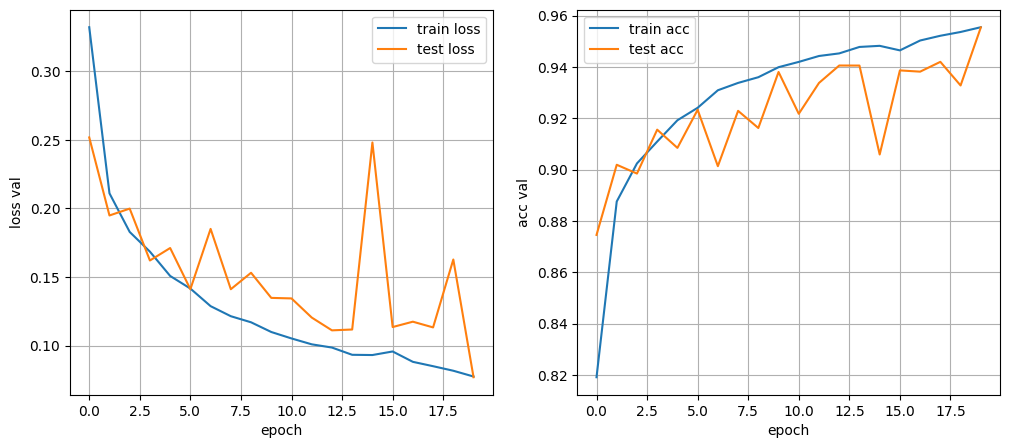

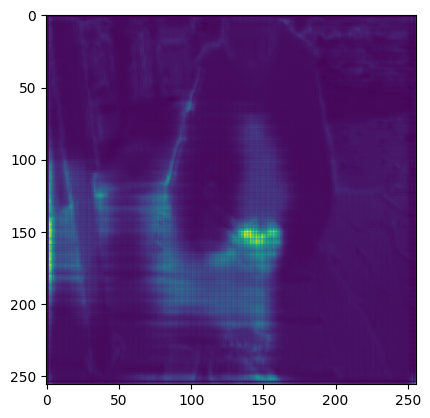

In [24]:
model=UNet().to(device)
model.to(device)
n_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr= 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-6)
criterion = diceloss()

history = train(model, optimizer, scheduler, train_loader, criterion, test_loader, n_epochs)

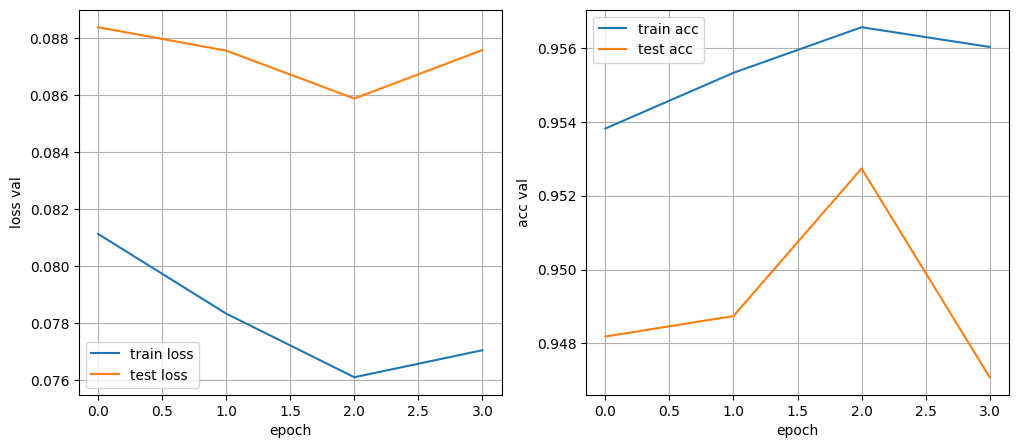

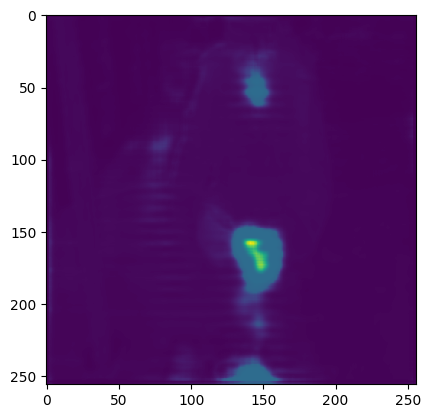

  7%|▋         | 8/120 [00:02<00:41,  2.70it/s]


KeyboardInterrupt: 

In [26]:
n_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr= 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-6)
criterion = diceloss()

history = train(model, optimizer, scheduler, train_loader, criterion, test_loader, n_epochs)

In [31]:
torch.save(model, "egohand_model_real.pt")

In [27]:
model.to("cpu");

In [28]:
image = torch.tensor(np.rollaxis(skimage.io.imread("EGOHAND/images/1000.jpg"), 2, 0)).float()
mask = torch.tensor(skimage.io.imread("EGOHAND/masks/1000.jpg")).float()

In [29]:
res = model(image.unsqueeze(dim=0))

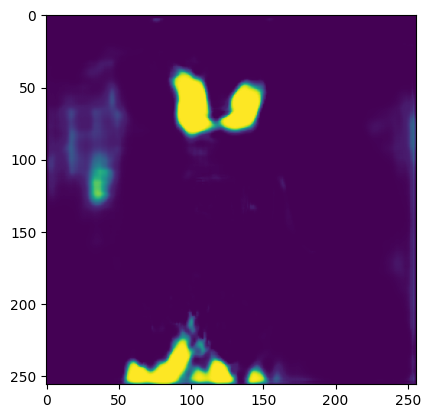

In [30]:
plt.imshow(res.detach().numpy()[0, 0])